In [3]:
import os
from PIL import Image, ImageEnhance, ImageFilter
import math
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import czifile
from pathlib import Path
import shutil
import csv
from scipy.ndimage import gaussian_filter
from tqdm.notebook import tqdm, trange

Image.MAX_IMAGE_PIXELS = 1000000000 ## working with large image files, need to increase max pixels to avoid DDOS error

In [4]:
## CREATING DIRECTORIES - **DO NOT RUN AGAIN, WILL RESET ALL IMAGES**
def create_dir():
    os.mkdir('images')
    directories = ['CZI','TIFF','MULTIPLIED','BACKGROUND_THRESHOLDED','SPLIT CHANNELS','CROPPED','HEATMAP']
    for i in directories:
        os.mkdir('images/' + i)
        
create_dir()
        
def create_dir_2():
    for i in range(len(names)):
        os.mkdir('images/CROPPED' + names[i])
        os.mkdir('images/CROPPED' + names[i] + '/c1')
        os.mkdir('images/CROPPED' + names[i] + '/c2')

create_dir_2()

In [14]:
## Load Images in - **ONLY NEED TO RUN ONCE**

tiff_paths = []
raw_tiff = [] ## imread image files
raw_arr = [] ## images as numpy arrays
names = []
colors = list(mcolors.BASE_COLORS) + list(mcolors.TABLEAU_COLORS)
del colors[7] ## get rid of white

## CONVERT CZI FILES IN PROGRESS

def read_czi(read_path,write_path):
    javabridge.start_vm(class_path=bioformats.JARS)
    
    image, scale = bioformats.load_image(read_path, rescale=False, wants_max_intensity=False)
    bioformats.write_image(write_path, image)
    
    javabridge.kill_vm()

def convert_czi(directory):
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        if os.path.isfile(f) and '.czi' in f:
            read_czi('images/CZI','images/TIFF')

def read_tiff(path):
    """
    path - Path to the multipage-tiff file
    """
    img = Image.open(path)
    arrays = []
    images = []
    
    images.append(img)
    arrays.append(np.array(img))
    for i in range(img.n_frames):
        img.seek(i)
        arrays.append(np.array(img))
        images.append(img)
    raw_tiff.append(images)
    return np.array(arrays)

def convert_tiff(directory,lst):
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        if os.path.isfile(f) and f != (directory+'/'+".DS_Store"):
            tiff_paths.append(f)
    print(len(tiff_paths))
    for path in tiff_paths:
        lst.append(read_tiff(path))
        
convert_tiff('images/TIFF',raw_arr)
print("Converted Tiffs")

8
Converted Tiffs


  0%|          | 0/8 [00:00<?, ?it/s]

processed
HBC-1713_CD8a_527 TMR.czi #1 - 239.51866958947898
(345653851, 82790550530)
HBC-1713_CD8a_503 LYN.czi #1 - 1591.9940922537778
(19152820, 30491176290)
HBC-1713_CD8a_521 TMR.czi #1 - 242.55184843596987
(335737813, 81433827133)
HBC-1713_CD8a_502 LYN.czi #1 - 900.2951699707048
(8514379, 7665454289)
HBC-1713_CD8a_527 LYN.czi #1 - 1828.5420108578228
(28075242, 51336759462)
HBC-1713_CD8a_503 TMR.czi #2 - 216.76368407842196
(158706285, 34401759023)
HBC-1713_CD8a_521 LYN.czi #1 - 510.2829190908239
(8022032, 4093505906)
HBC-1713_CD8a_502 TMR.czi #2 - 183.68237158107863
(125470237, 23046670695)


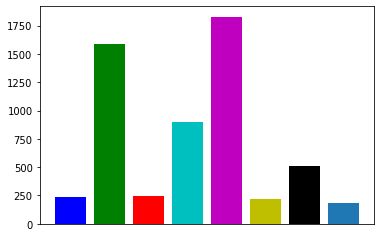

In [29]:

## INTENSITY BASED ANALYSIS

img_thresholded = []
img_multiplied = []
signal_binary = []
img_integrals = []
img_ratios = []

def threshold_img(img, threshold, name):
    thresholded = np.where(img > threshold, 1, 0)
    thresholded = thresholded.astype(np.uint16)
    
    save_img('images/BACKGROUND_THRESHOLDED',thresholded,'thres',name)               # SAVE IMAGE
    return thresholded

def otsu_threshold_img(img, name):
    otsu_thres = cv2.threshold(img, 0, 1, c]v2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    save_img('images/OTSU_THRESHOLDED',otsu_thres,'otsu_thres',name)               # SAVE IMAGE
    return otsu_thres

def multiply_img(img, background, name):
    multiplied = np.multiply(np.array(img),np.array(background))
    multiplied = multiplied.astype(np.uint16)

    save_img('images/MULTIPLIED',multiplied,'mult',name)                  # SAVE IMAGE
    return multiplied

def binary_img(img, name):
    binary = np.where(img > 0, 1, 0)
    save_img('images/BINARY',binary,'binary',name)
    return binary

def summation(background, signals):
    return (np.sum(background), np.sum(signals))

def save_img(path,arr,prefix,name):
    img = Image.fromarray(arr.astype(np.uint16))
    img.save(path + '/' + prefix + ' ' + name + '.tif')

names = [path[12:path.find('.tif')] for path in tiff_paths]


## PROCESSING ALL OF THE IMAGES

for i in trange(len(raw_arr)):
    img_thresholded.append(otsu_threshold_img(raw_arr[i][1], names[i]))
    img_multiplied.append(multiply_img(raw_arr[i][2], img_thresholded[i], names[i]))
    img_integrals.append(summation(img_thresholded[i], img_multiplied[i]))
    img_ratios.append(img_integrals[i][1]/img_integrals[i][0])
    
print('processed')
    
## DATA PRESENTATION
for i in range(len(names)):
    print(names[i], '-', img_ratios[i])
    print(img_integrals[i])
plt.bar(names, img_ratios,color=colors[:len(names)])
plt.xticks([])
plt.show()

In [26]:
## HEAT MAP OF IMAGES - GAUSSIAN BLUR, save in images/HEATMAP
def gauss_blur():
    for i in range(len(names)):
        img = raw_tiff[i].convert('I;16').filter(ImageFilter.GaussianBlur(radius = 60))
        img.save('images/HEATMAP/heatmap', names[i])
    print('done')
    
gauss_blur()

In [24]:
## CELL PROFILER CELL-BASED ANALYSIS

import cellprofiler_core.pipeline
import cellprofiler_core.preferences
import cellprofiler_core.utilities.java
import cellprofiler.modules.identifyprimaryobjects

cp_data = np.empty(shape=(len(names),2))

# BATCH IMAGES
def crop_image(directory,img,w,h):
    cropped_lst = []
    crop_w = math.floor(img.size[0]/w)
    crop_h = math.floor(img.size[1]/h)
    for i in range(0,h):
        for j in range(0,w):
            (img.crop((j*crop_w, i*crop_h, j*crop_w+crop_w, i*crop_h+crop_h))).save(directory+'_cropped'+str(i*w+j)+'.tif')
            
## CROP SIGNALS
def crop_signals():
    for filename in os.listdir('images/MULTIPLIED'):
        f = os.path.join('images/MULTIPLIED', filename)
        if os.path.isfile(f) and 'HBC' in f:
            crop_image(('images/CROPPED/' + filename[5:filename.find('.tif')] + '/c2/'),(Image.open(f)),30,30)
            print(filename)
    
## THRESHOLDED DAPI
def threshold_dapi(thres,back,name):
    multiplied = np.multiply(np.array(thres),np.array(back))
    multiplied = multiplied.astype(np.uint16)

    save_img('images/BACKGROUND_MULT',multiplied,'backmult',name)                  # SAVE IMAGE

def crop_dapi():
    for filename in os.listdir('images/BACKGROUND_MULT'):
        f = os.path.join('images/BACKGROUND_MULT', filename)
        if os.path.isfile(f) and 'HBC' in f:
            crop_image(('images/CROPPED/' + filename[9:filename.find('.tif')] + '/c1/'),(Image.open(f)),30,30)
            print(filename)

def cp_analyse(path):
    cellprofiler_core.preferences.set_headless()

    cellprofiler_core.utilities.java.start_java()

    pipeline = cellprofiler_core.pipeline.Pipeline()
    pipeline.load('cellprofiler_analysis.cppipe')

    file_list = list(pathlib.Path('.').absolute().glob(path+'/*.tif'))
    files = [file.as_uri() for file in file_list]
    pipeline.read_file_list(files)

    output_measurements = pipeline.run()
    
    return_value = len(output_measurements.get_measurement_columns())

    cellprofiler_core.utilities.java.stop_java()
    return return_value

def analyse_all():
    for i in range(len(names)):
        cp_data[i][0].append(cp_analyse('images/CROPPED/' + names[i] + '/c1'))
        c2_data[i][1].append(cp_analyse('images/CROPPED/' + names[i] + '/c2'))

def read_csv(filename):
    csv_data = []
    with open(filename) as csv_data_file:
        csv_reader = csv.reader(csv_data_file)
        for row in csv_reader:
            csv_data.append(row[1])
    return len(csv_data)


def process_results():
    for i in range(len(names)):
        cp_data[i][0] = read_csv('images/CROPPED/' + names[i] + '/c1/' + names[i] + ' c1IdentifyPrimaryObjects.csv')
        cp_data[i][1] = read_csv('images/CROPPED/' + names[i] + '/c2/' + names[i] + ' c2IdentifyPrimaryObjects.csv')
    

## DATA PRESENTATION
def do_the_data():
    for i in range(len(names)):
        print(names[i], '-', cell_ratios[i], '-', cp_data[i][0], '-', cp_data[i][1])
    plt.bar(names, cell_ratios,color=colors[:len(names)])
    plt.xticks([])
    plt.show()
    
    
crop_signals()
for i in range(len(names)):
    threshold_dapi(img_thresholded[i],raw_arr[i][0],names[i])
crop_dapi()
crop_22()
print('done')
    
process_results()
cell_ratios = [datum[0]/datum[1] for datum in cp_data]
do_the_data()

  0%|          | 0/8 [00:00<?, ?it/s]

HBC-1713_CD8a_527 TMR.czi #1
HBC-1713_CD8a_503 LYN.czi #1
HBC-1713_CD8a_521 TMR.czi #1
HBC-1713_CD8a_502 LYN.czi #1
HBC-1713_CD8a_527 LYN.czi #1
HBC-1713_CD8a_503 TMR.czi #2
HBC-1713_CD8a_521 LYN.czi #1
HBC-1713_CD8a_502 TMR.czi #2
done
